Importing Necessary Library

In [1]:
# Importing Necessary Libraries
import wandb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications import resnet
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

2025-04-13 14:31:58.383168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744554718.406384    2544 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744554718.413181    2544 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading the Dataset

In [2]:
config = {
    'path_dir': "/kaggle/input/monkeypox-detection-dataset/converted_data"
}
config

{'path_dir': '/kaggle/input/monkeypox-detection-dataset/converted_data'}

In [3]:
# Initialize Weights & Biases
wandb.login(key="e8a360829806e69a22f56a7eb4c7b07aab8c6485")
wandb.init(project="final-project-new-ablations", name="amuhairw_final_project_trial1")

print("[INFO] loading images...")
imagePaths = list(paths.list_images(config['path_dir']))
data = []
labels = []

print(f"Number of image paths loaded: {len(imagePaths)}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amuhairw (delta-group-50) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


[INFO] loading images...
Number of image paths loaded: 90


In [4]:
# Define paths directly
root_dir = config["path_dir"]
monkeypox_label = "Monkeypox_gray"
monkeypox_path = f"{root_dir}/{monkeypox_label}"
# chickenpox_path = f"config["path_dir"]/chicken_pox"
chickenpox_label = "Chickenpox_grayscale" #"chicken_pox"
chickenpox_path = f"{root_dir}/{chickenpox_label}"

# Function to load images from a directory with a specific label
def load_images_from_folder(folder, label):
    images = []
    labels_list = []
    count = 0

    # Check if directory exists
    if not os.path.exists(folder):
        print(f"Warning: {folder} directory does not exist")
        return images, labels_list

    # Load all images from the directory
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))  # Resize to match VGG16 input
                images.append(image)
                labels_list.append(label)
                count += 1

    print(f"Loaded {count} images from {folder}")
    return images, labels_list

# Load Chickenpox images
chickenpox_images, chickenpox_labels = load_images_from_folder(chickenpox_path, chickenpox_label)

# Load Monkeypox images
monkeypox_images, monkeypox_labels = load_images_from_folder(monkeypox_path, monkeypox_label)

# Combine the data
data = chickenpox_images + monkeypox_images
labels = chickenpox_labels + monkeypox_labels

# Convert to numpy arrays
data = np.array(data, dtype="float32") / 255.0  # Normalize pixel values
labels = np.array(labels)

print(f"Final dataset size: {len(data)} images")
print(f"Unique labels: {np.unique(labels)}")
print(f"Label counts: {[(label, (labels == label).sum()) for label in np.unique(labels)]}")

Loaded 47 images from /kaggle/input/monkeypox-detection-dataset/converted_data/Chickenpox_grayscale
Loaded 43 images from /kaggle/input/monkeypox-detection-dataset/converted_data/Monkeypox_gray
Final dataset size: 90 images
Unique labels: ['Chickenpox_grayscale' 'Monkeypox_gray']
Label counts: [('Chickenpox_grayscale', 47), ('Monkeypox_gray', 43)]


Image preprocessing and extract the Label

In [5]:
# Create dictionaries to store data by class
class_data = {monkeypox_label: [], chickenpox_label: []}
for img, lbl in zip(data, labels):
    class_data[lbl].append(img)

# Create train and test sets with specific counts
trainX = []
testX = []
trainY = []
testY = []

# Monkeypox: 34 train, 9 test
monkey_images = class_data[monkeypox_label]
if len(monkey_images) >= 43:
    monkey_train = monkey_images[:34]
    monkey_test = monkey_images[34:43]
    trainX.extend(monkey_train)
    testX.extend(monkey_test)
    trainY.extend([monkeypox_label] * len(monkey_train))
    testY.extend([monkeypox_label] * len(monkey_test))
else:
    print(f"Warning: Not enough Monkeypox images. Found {len(monkey_images)}, need 43")

# Chickenpox: 38 train, 9 test
chicken_images = class_data[chickenpox_label]
if len(chicken_images) >= 47:
    chicken_train = chicken_images[:38]
    chicken_test = chicken_images[38:47]
    trainX.extend(chicken_train)
    testX.extend(chicken_test)
    trainY.extend([chickenpox_label] * len(chicken_train))
    testY.extend([chickenpox_label] * len(chicken_test))
else:
    print(f"Warning: Not enough Chickenpox images. Found {len(chicken_images)}, need 47")

# Convert to numpy arrays
trainX = np.array(trainX, dtype="float32")
testX = np.array(testX, dtype="float32")
trainY = np.array(trainY)
testY = np.array(testY)

print(f"Train data shape: {trainX.shape}, Train labels shape: {trainY.shape}")
print(f"Test data shape: {testX.shape}, Test labels shape: {testY.shape}")

Train data shape: (72, 224, 224, 3), Train labels shape: (72,)
Test data shape: (18, 224, 224, 3), Test labels shape: (18,)


In [6]:
# Convert labels to categorical (if needed)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load pre-trained VGG16 (convolution + maxpool only; no Dense "top")
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

# Build your "modified" classification head:
headModel = baseModel.output
# Optionally remove your custom MaxPool(4x4), as VGG16 already has max pool layers.
# headModel = MaxPooling2D(pool_size=(4, 4))(headModel)  # (Likely remove this if you want standard flow)

headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)   # 1st Dense
headModel = Dropout(0.5)(headModel)                    # Dropout
headModel = Dense(256, activation="relu")(headModel)   # 2nd Dense
headModel = Dense(128, activation="relu")(headModel)   # 3rd Dense
headModel = Dense(2, activation="softmax")(headModel)  # Final classification

# Combine base + new head
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the base model layers for initial training
for layer in baseModel.layers:
    layer.trainable = False

I0000 00:00:1744554734.457347    2544 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
# model.summary()

In [9]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 30

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import tensorflow as tf
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [12]:
# Compile the model
print("[INFO] compiling model...")
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.compile(optimizer="adam", loss="categorical_crossentropy", 
              metrics=["accuracy"])

# # Start timing
# t1 = time.process_time()

# Train the model
print("[INFO] training head...")
wandb_callback = wandb.keras.WandbMetricsLogger(log_freq="epoch")
import time
t1=time.process_time()
H = model.fit(
    x=trainX, 
    y=trainY, 
    batch_size=BS,
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
     callbacks=[wandb_callback]
)

# End timing
t2 = time.process_time()
print("Process time:", t2 - t1)

[INFO] compiling model...
[INFO] training head...
Epoch 1/100


I0000 00:00:1744554738.616700    2618 service.cc:148] XLA service 0x79b778005a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744554738.616755    2618 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744554738.937111    2618 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5083 - loss: 2.0601

I0000 00:00:1744554746.258200    2618 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.5111 - loss: 2.4729 - val_accuracy: 0.5000 - val_loss: 0.8239
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7500 - loss: 0.4863 - val_accuracy: 0.5000 - val_loss: 1.1812
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6778 - loss: 1.0452 - val_accuracy: 0.5000 - val_loss: 1.5046
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5833 - loss: 1.6024 - val_accuracy: 0.6667 - val_loss: 0.5873
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5889 - loss: 1.2999 - val_accuracy: 0.5000 - val_loss: 1.0347
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6667 - loss: 1.4092 - val_accuracy: 0.6667 - val_loss: 0.6752
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6222 - loss: 0.9728 - val_accuracy: 0.5000 - val_loss: 0.8888
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6667 - loss: 1.2982 - val_accuracy: 0.6111 - val_loss: 0.5756
Ep

In [13]:
print(len(H.history['loss']))

100


In [14]:
model.save_weights("my_model_weights.weights.h5")

In [15]:
# Log model weights to W&B as an artifact
artifact = wandb.Artifact("monkeypox-model", type="model")
artifact.add_file("my_model_weights.weights.h5")
wandb.log_artifact(artifact)

#classification report on training
predIdxs = model.predict(trainX)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
trainpredict = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), trainpredict,
	target_names=lb.classes_))

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
                      precision    recall  f1-score   support

Chickenpox_grayscale       1.00      0.95      0.97        38
      Monkeypox_gray       0.94      1.00      0.97        34

            accuracy                           0.97        72
           macro avg       0.97      0.97      0.97        72
        weighted avg       0.97      0.97      0.97        72



In [16]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(trainY.argmax(axis=1), trainpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# Log metrics to W&B
wandb.log({
    "train_accuracy": acc,
    "train_sensitivity": sensitivity,
    "train_specificity": specificity
})

[[36  2]
 [ 0 34]]
acc: 0.9722
sensitivity: 0.9474
specificity: 1.0000


In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdys = model.predict(testX, batch_size=BS)
testpredict = np.argmax(predIdys, axis=1)
print(classification_report(testY.argmax(axis=1), testpredict,
	target_names=lb.classes_))

[INFO] evaluating network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
                      precision    recall  f1-score   support

Chickenpox_grayscale       0.78      0.78      0.78         9
      Monkeypox_gray       0.78      0.78      0.78         9

            accuracy                           0.78        18
           macro avg       0.78      0.78      0.78        18
        weighted avg       0.78      0.78      0.78        18



In [18]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), testpredict)
total = sum(sum(cm))
print(cm)
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# Log test metrics to W&B
wandb.log({
    "test_accuracy": acc,
    "test_sensitivity": sensitivity,
    "test_specificity": specificity
})

[[7 2]
 [2 7]]
acc: 0.7778
sensitivity: 0.7778
specificity: 0.7778


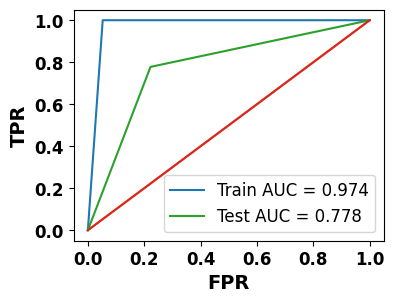

<Figure size 640x480 with 0 Axes>

In [19]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
fig = plt.figure(figsize = (4, 3))
fpr1,tpr1,_=roc_curve(np.argmax(trainY, axis=1),np.argmax(predIdxs, axis=1))
fpr2,tpr2,_=roc_curve(np.argmax(testY, axis=1),np.argmax(predIdys, axis=1))
area_under_curve1=auc(fpr1,tpr1)
random_probs=[0 for i in range(len(trainY.ravel()))]
p_fpr1,p_tpr1,threshold=roc_curve(trainY.ravel(),random_probs, pos_label=1)
plt.plot(fpr1,tpr1, label='Train AUC = {:.3f}'.format(area_under_curve1))
plt.plot(p_fpr1, p_tpr1)
area_under_curve2=auc(fpr2,tpr2)
random_probs2=[0 for i in range(len(testY.ravel()))]
p_fpr2,p_tpr2,threshold=roc_curve(testY.ravel(),random_probs2, pos_label=1)
plt.plot(fpr2,tpr2, label='Test AUC = {:.3f}'.format(area_under_curve2))
plt.plot(p_fpr2, p_tpr2)

    # x label
plt.xlabel('FPR',fontsize=14, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('TPR', fontsize=14, fontdict=dict(weight='bold'))
plt.xticks( rotation=0, weight = 'bold', )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=12)
plt.tick_params(rotation=0,axis='x', labelsize=12)
plt.legend()
plt.legend(prop={'size':12})
plt.savefig('ROC',dpi=200, bbox_inches='tight')
plt.show();

# Log ROC curve to W&B
wandb.log({"ROC_curve": wandb.Image(plt)})

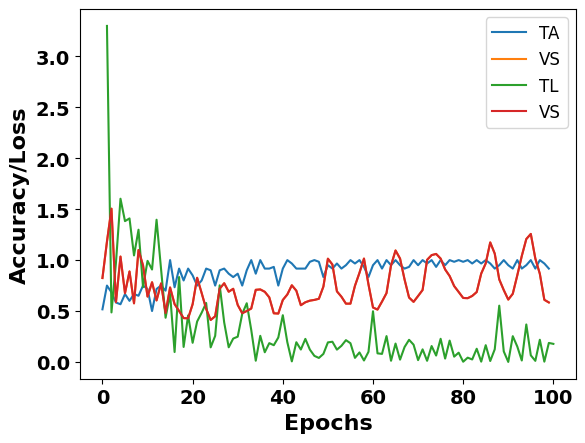

<Figure size 640x480 with 0 Axes>

In [20]:
from matplotlib.ticker import FormatStrFormatter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

N=len(H.history['loss'])
fig, ax = plt.subplots()
#plt.rcParams["font.family"] = "serif"
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
#font={'size':10}
#matplotlib.rc('font',**font)
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="TA")
#plt.plot(epochs, loss, label='Training loss')
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="VA")
plt.plot(np.arange(0, len(val_loss)), val_loss, label='VS')

plt.plot(epochs, loss, label='TL')
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.plot(np.arange(0, N), val_loss, label='VS')
#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(1, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs',fontsize=16, fontdict=dict(weight='bold'))
    # y label
plt.ylabel('Accuracy/Loss', fontsize=16, fontdict=dict(weight='bold'))
#plt.ylabel("Accuracy")
#plt.xlabel("Epochs")
plt.xticks( rotation=0, weight = 'bold' )
plt.yticks( rotation=0, weight = 'bold')
plt.tick_params(rotation=0,axis='y', labelsize=14)
plt.tick_params(rotation=0,axis='x', labelsize=14)
#plt.grid('white')
#plt.grid(axis='x', color='0.95')
plt.legend(loc='best')
plt.legend(prop={'size':12})
#fig = plt.figure(figsize = (4, 3))
plt.savefig('ACC',dpi=200, bbox_inches='tight')
plt.show()

wandb.init()

# Log accuracy/loss plot to W&B
wandb.log({"Accuracy_Loss_Plot": wandb.Image(plt)})


In [21]:
# Finish W&B run
wandb.finish()

epoch/accuracy,▁▅▂▂▃▁▄▄█▇▅▇▇▆█▇▇▇▇▇█▆█▇▇▇█▇▇█▇█████▇▇█▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▃█▇▆▇▅▇▁▃▄▃▂▃▂▁▂▂▁▂▂▁▁▂▂▂▁▃▁▂▂▂▁▁▁▁▂▃▁▂▂
epoch/val_accuracy,▁▁▁▃▅▃▂▆▇▇███▇▇▇▇▇▆▆▆▆▆▇▇█▇▇▇█▆▆▇▇▇▇▇▇▇▇
epoch/val_loss,▇▂▆▂▅▄▃▄▂▄▁▄▄▃▂▃▂▃▃▂▃▃▂▂▅▂▂▅▃▂▆▆▃▃▃▆▃█▆▃
test_accuracy,▁
test_sensitivity,▁
test_specificity,▁
train_accuracy,▁
train_sensitivity,▁
